In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sphot.utils import load_and_crop, prep_model
from sphot.psf import PSFFitter
from sphot.fitting import ModelFitter, ModelScaleFitter
from sphot.plotting import plot_sphot_results

import matplotlib.pyplot as plt
import multiprocessing as mp
import glob
import sys
from warnings import filterwarnings

In [3]:
folder_PSF = 'PSF/'
data_folder = 'cutouts_DDU/'
out_folder = 'sphot_out/'
filters = ['F555W','F814W','F090W','F150W','F160W','F277W']
base_filter = 'F150W'
N_mainloop_iter = 7
fit_complex_model = False
allow_refit = False # whether to fit Sersic parameter to each filter
blur_psf = dict(zip(filters,[5,5,3.8,3.8,9,7]))

datafile = 'cutouts_DDU/g268.h5'

# Run the entire process

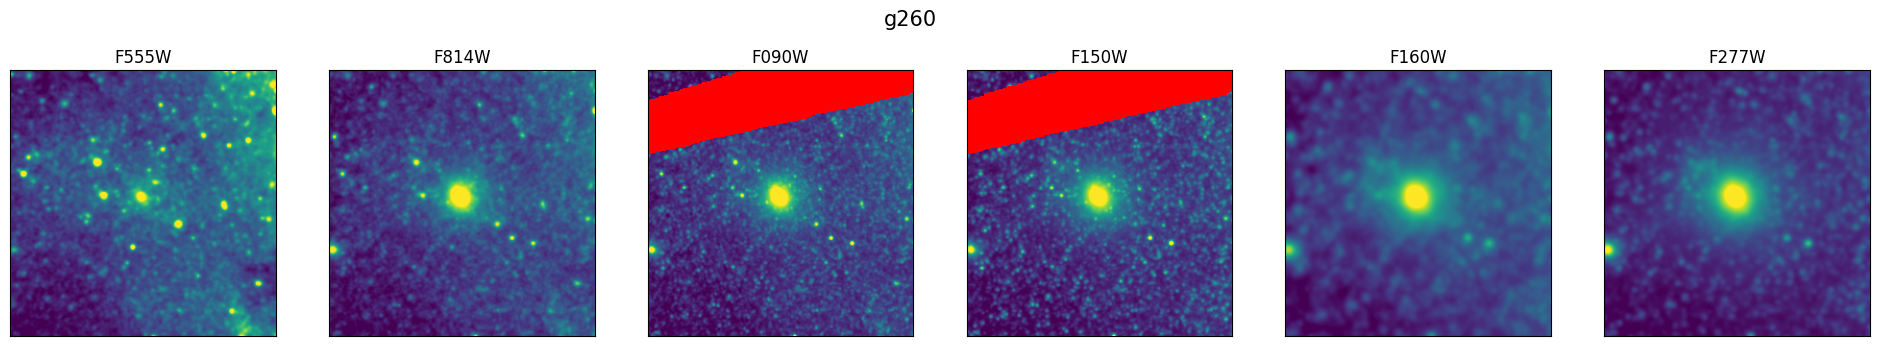

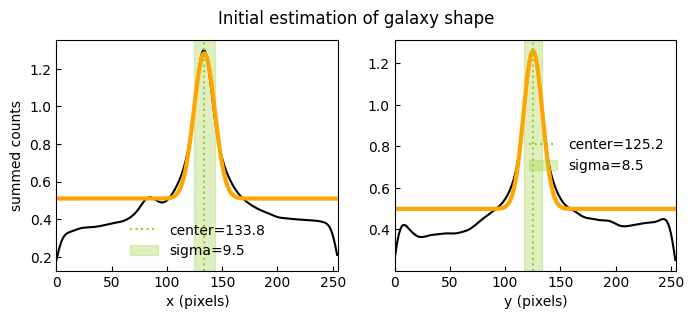

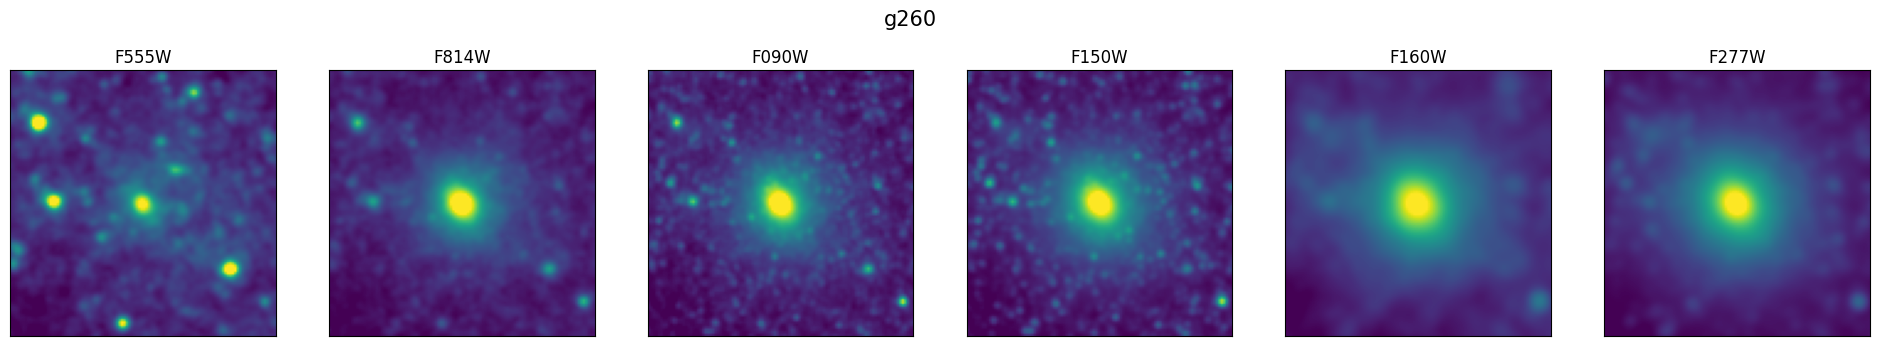

In [115]:
try:
    galaxy = load_and_crop(datafile,filters,folder_PSF,
                            'F277W',plot=True,
                            custom_initial_crop=1,
                            sigma_guess=10)
except Exception as e:
    debug_var = e.debug_var

In [116]:
# 2. select base filter to fit
cutoutdata = galaxy.images[base_filter]
cutoutdata.perform_bkg_stats()
cutoutdata.blur_psf(blur_psf[base_filter])

# 3. make models & prepare fitters
model_1 = prep_model(cutoutdata,simple=True)
fitter_1 = ModelFitter(model_1,cutoutdata)
if fit_complex_model:
    model_2 = prep_model(cutoutdata,simple=False)
    fitter_2 = ModelFitter(model_2,cutoutdata)
else:
    model_2 = model_1
    fitter_2 = fitter_1
fitter_psf = PSFFitter(cutoutdata)

In [117]:
# 4. fit 
print(f'Fitting the base filter {base_filter}...')
fitter_1.fit(fit_to='data',max_iter=20)
fitter_psf.fit(fit_to='sersic_residual',plot=False)
fitter_2.fit(fit_to='psf_sub_data',
            method='iterative_NM',max_iter=30)
for _ in range(N_mainloop_iter):
    fitter_2.fit(fit_to='psf_sub_data',method='iterative_NM',max_iter=15)
    fitter_psf.fit(fit_to='sersic_residual',plot=False)
galaxy.save(out_folder+f'{galaxy.name}_sphot.h5')

Fitting the base filter F150W...


 43%|████▎     | 13/30 [01:31<01:59,  7.00s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/15 [00:05<?, ?it/s]


Iterative Nelder-Mead method Converged



  7%|▋         | 1/15 [00:11<02:41, 11.57s/it]


Iterative Nelder-Mead method Converged



  7%|▋         | 1/15 [00:12<02:58, 12.72s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/15 [00:06<?, ?it/s]


Iterative Nelder-Mead method Converged



  7%|▋         | 1/15 [00:12<02:58, 12.76s/it]


Iterative Nelder-Mead method Converged



  7%|▋         | 1/15 [00:11<02:44, 11.76s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/15 [00:05<?, ?it/s]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:23<00:00,  2.95s/it]


Saved to sphot_out/g260_sphot.h5


# Run each filter individually

In [4]:
%load_ext autoreload
%autoreload 2
from sphot.core import run_basefit, run_scalefit
from sphot.data import read_sphot_h5
# from rich.progress import Progress


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
base_filter = 'F150W'
fit_complex_model = True
allow_refit = False 
filters = ['F555W','F814W','F090W','F150W','F160W','F277W']
blur_psf = dict(zip(filters,[5,5,3.8,3.8,9,7]))
out_folder = 'sphot_out_May23/'

galaxy = read_sphot_h5('sphot_out/May23/g310_sphot.h5')

In [6]:
# with Progress(transient=False) as progress:
run_basefit(galaxy,
            base_filter='F150W',
            fit_complex_model=False,
            blur_psf=blur_psf,
            N_mainloop_iter=7,)
            # progress=progress)

Output()

In [6]:
base_params = galaxy.images[base_filter].sersic_params
run_scalefit(galaxy,'F277W',base_params,
            allow_refit=allow_refit,
            fit_complex_model=fit_complex_model,
            N_mainloop_iter=7,
            blur_psf=blur_psf)

Output()

In [5]:
from sphot.data import read_sphot_h5
base_filter = 'F150W'
N_mainloop_iter = 7
fit_complex_model = True
allow_refit = False # whether to fit Sersic parameter to each filter
blur_psf = dict(zip(filters,[5,5,3.8,3.8,9,7]))
out_folder = 'sphot_out_May23/'

galaxy = read_sphot_h5('sphot_out_May23/g310_sphot.h5')

In [21]:
base_params = galaxy.images[base_filter].sersic_params
with Progress(transient=False) as progress:
    run_phase2(galaxy,'F277W',base_params,
            allow_refit=allow_refit,
            fit_complex_model=fit_complex_model,
            blur_psf=blur_psf,progress=progress)
# galaxy.save(out_folder+f'{galaxy.name}_sphot.h5')

Output()

*** working on F277W ***

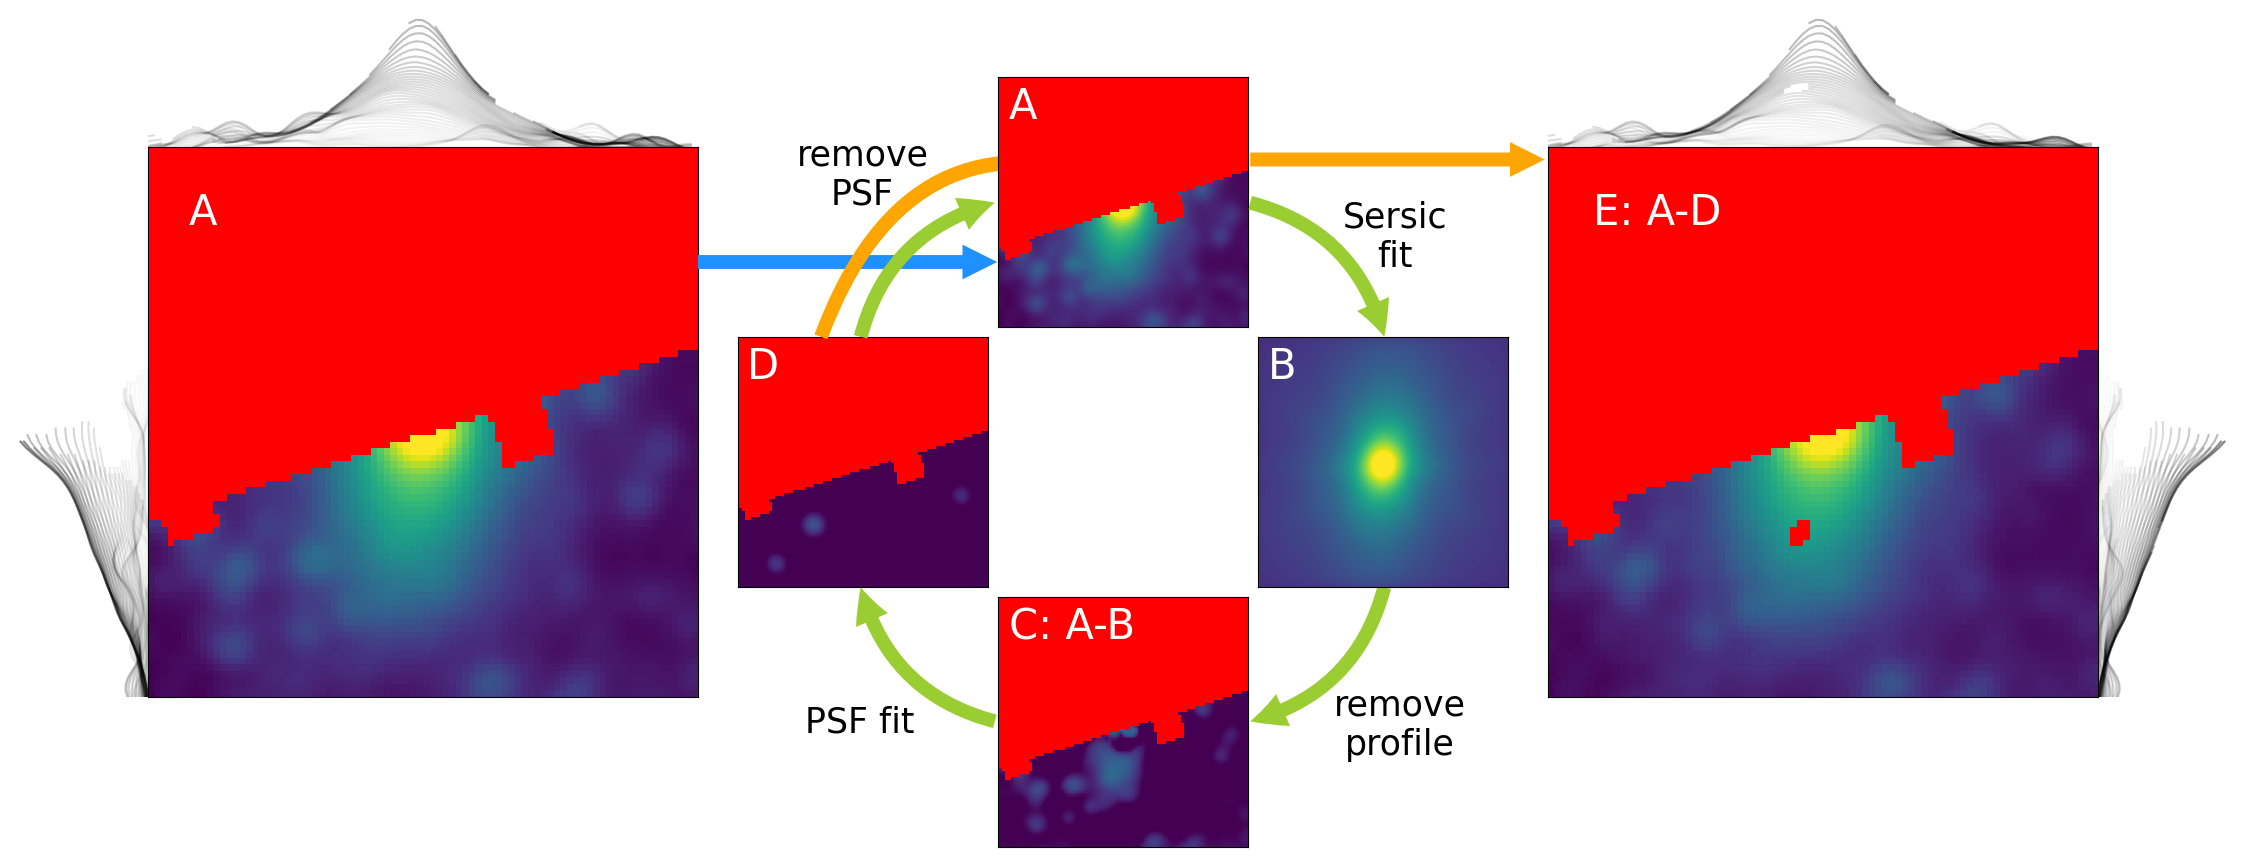

In [35]:
plot_sphot_results(galaxy.F277W)

In [71]:
base_params = cutoutdata.sersic_params
for filt in galaxy.filters:
    run_phase2(galaxy,filt,base_params,allow_refit=True)
    galaxy.save(out_folder+f'{galaxy.name}_sphot.h5')


*** working on F555W ***
 8.9912e-01 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 8.8992e-01 (iter=2: fatol=8.90e-04)   

 10%|█         | 1/10 [00:00<00:01,  7.69it/s]


Iterative Nelder-Mead method Converged



 15%|█▌        | 3/20 [00:01<00:08,  1.91it/s]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:01<00:03,  1.79it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:01<00:04,  2.00it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:00<00:03,  2.32it/s]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

Saved to sphot_out/g321_sphot.h5

*** working on F814W ***
 2.3773e+00 (iter=0)   

 1.2760e+00 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 1.2727e+00 (iter=2: fatol=1.27e-03)   
Iterative Nelder-Mead method Converged


 10%|█         | 2/20 [00:01<00:14,  1.21it/s]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:02<00:05,  1.34it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:01<00:05,  1.37it/s]


Iterative Nelder-Mead method Converged



 50%|█████     | 5/10 [00:03<00:03,  1.52it/s]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



 40%|████      | 4/10 [00:02<00:03,  1.59it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:01<00:06,  1.22it/s]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Saved to sphot_out/g321_sphot.h5

*** working on F090W ***
 1.3508e+00 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 1.3022e+00 (iter=1: fatol=1.35e-03)   

 10%|█         | 1/10 [00:00<00:05,  1.73it/s]

 1.3024e+00 (iter=2: fatol=1.30e-03)   

 10%|█         | 1/10 [00:00<00:08,  1.11it/s]


Iterative Nelder-Mead method Converged



 10%|█         | 2/20 [00:13<01:58,  6.59s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:03<?, ?it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:11<00:47,  5.97s/it]


Iterative Nelder-Mead method Converged



 60%|██████    | 6/10 [00:25<00:16,  4.24s/it]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:10<00:43,  5.47s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:03<?, ?it/s]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:14<00:34,  4.91s/it]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:10<00:42,  5.35s/it]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:45<00:00,  5.66s/it]


Saved to sphot_out/g321_sphot.h5

*** working on F150W ***
 1.3947e+00 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 1.3940e+00 (iter=1: fatol=1.39e-03)   

 10%|█         | 1/10 [00:00<00:03,  2.94it/s]

 1.3947e+00 (iter=2: fatol=1.39e-03)   

 10%|█         | 1/10 [00:00<00:06,  1.47it/s]


Iterative Nelder-Mead method Converged



 20%|██        | 4/20 [00:25<01:40,  6.26s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:04<?, ?it/s]


Iterative Nelder-Mead method Converged



 50%|█████     | 5/10 [00:27<00:27,  5.56s/it]


Iterative Nelder-Mead method Converged



 60%|██████    | 6/10 [00:28<00:19,  4.79s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:15<00:36,  5.21s/it]


Iterative Nelder-Mead method Converged



 40%|████      | 4/10 [00:22<00:33,  5.61s/it]


Iterative Nelder-Mead method Converged



 40%|████      | 4/10 [00:20<00:31,  5.18s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:17<00:40,  5.73s/it]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:58<00:00,  7.37s/it]


Saved to sphot_out/g321_sphot.h5

*** working on F160W ***
 9.3395e-01 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 9.3395e-01 (iter=1: fatol=9.34e-04)   

  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



  5%|▌         | 1/20 [00:03<01:05,  3.47s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:01<?, ?it/s]


Iterative Nelder-Mead method Converged



 80%|████████  | 8/10 [00:15<00:03,  1.91s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:08<00:18,  2.68s/it]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:06<00:25,  3.24s/it]


Iterative Nelder-Mead method Converged



 70%|███████   | 7/10 [00:14<00:06,  2.06s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:06<00:16,  2.32s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:07<00:18,  2.61s/it]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:24<00:00,  3.00s/it]


Saved to sphot_out/g321_sphot.h5

*** working on F277W ***
 2.7920e+00 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 2.7883e+00 (iter=1: fatol=2.79e-03)   

 10%|█         | 1/10 [00:00<00:04,  1.92it/s]

 2.7887e+00 (iter=2: fatol=2.79e-03)   

 10%|█         | 1/10 [00:01<00:09,  1.04s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 6/20 [00:32<01:16,  5.49s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:04<?, ?it/s]


Iterative Nelder-Mead method Converged



 50%|█████     | 5/10 [00:27<00:27,  5.50s/it]


Iterative Nelder-Mead method Converged



 10%|█         | 1/10 [00:09<01:29,  9.93s/it]


Iterative Nelder-Mead method Converged



 10%|█         | 1/10 [00:09<01:26,  9.58s/it]


Iterative Nelder-Mead method Converged



 30%|███       | 3/10 [00:18<00:42,  6.03s/it]


Iterative Nelder-Mead method Converged



 40%|████      | 4/10 [00:20<00:30,  5.15s/it]


Iterative Nelder-Mead method Converged



 20%|██        | 2/10 [00:13<00:53,  6.74s/it]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]

Saved to sphot_out/g321_sphot.h5


In [33]:
run_phase2(galaxy,'F277W',base_params)


*** working on F277W ***
 9.6225e-01 (iter=0)   

  0%|          | 0/10 [00:00<?, ?it/s]

 9.6314e-01 (iter=1: fatol=9.62e-04)   

  0%|          | 0/10 [00:00<?, ?it/s]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/Users/sterling/Dropbox/projects/sphot/sphot/fitting.py:366: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(func,x0,bounds=bounds,
 30%|███       | 6/20 [00:44<01:43,  7.38s/it]


Iterative Nelder-Mead method Converged



  0%|          | 0/10 [00:04<?, ?it/s]


Iterative Nelder-Mead method Converged



 70%|███████   | 7/10 [00:36<00:15,  5.18s/it]


Iterative Nelder-Mead method Converged



100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


In [ ]:
# re-run some stuff
from sphot.data import read_sphot_h5
galaxy_loaded = read_sphot_h5('sphot_out/g198_sphot.h5')

In [ ]:
_cutoutdata = galaxy.images[filtername]

# basic statistics
_cutoutdata.perform_bkg_stats()
_cutoutdata.blur_psf(4)

# initialize model and fitters
if fit_complex_model:
    _model = prep_model(_cutoutdata,simple=False)
else:
    _model = prep_model(_cutoutdata,simple=True)
_fitter_scale = ModelScaleFitter(_model,_cutoutdata,base_params)
_fitter_2 = ModelFitter(_model,_cutoutdata)
_fitter_psf = PSFFitter(_cutoutdata)

# run fitting
_fitter_scale.fit(fit_to='data')
_fitter_psf.fit(fit_to='sersic_residual',plot=False)
_fitter_2.model.x0 = _cutoutdata.sersic_params
_fitter_2.fit(fit_to='psf_sub_data',max_iter=20)
for _ in range(N_mainloop_iter):
    _fitter_2.fit(fit_to='psf_sub_data',max_iter=10)
    _fitter_psf.fit(fit_to='sersic_residual',plot=False)